# Generate input data

In [ ]:
from scipy.optimize import root
from numpy import sign
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"})

def generate_random_signal(T,N,p=1.5,u_max=0.2): 
    k = np.linspace(0, T, T)  
    a = np.random.randn(N)
    u = np.zeros_like(k)
    for n in range(1, N + 1):
        u += (a[n - 1] / n**p) * np.sin(2*np.pi*n*k/N)
    u = np.array(u)
    u = u/(np.max(u) - np.min(u))*u_max
    return u

# Implementation of hardening models

In [ ]:


materials = {
    'isotropic-swift': {
        'E' : 2e9,
        'Y' : lambda λ : 100e6*(0.0003+λ)**0.3,
        'dalpha': lambda alpha, deps_p, dλ : 0,
    },
    'isotropic-linear': {
        'E' : 2e9,
        'Y' : lambda λ : (50e6/200e6+λ)*200e6,
        'dalpha': lambda alpha, deps_p, dλ : 0,
    },
    'kinematic-linear': {
        'E' : 2e9,
        'Y' : lambda λ : 50e6,
        'dalpha': lambda alpha, deps_p, dλ : 200e6*deps_p,
    },
    'mixed-linear': {
        'E' : 2e9,
        'Y' : lambda λ : (100e6/200e6+λ)*100e6,
        'dalpha': lambda alpha, deps_p, dλ : 100e6*deps_p,
    },
    'mixed-armstrong-friedrick': {
        'E' : 2e9,
        'Y' : lambda λ : (100e6/200e6+λ)*100e6,
        'dalpha' : lambda alpha, deps_p, dλ : 100e6*deps_p-dλ*100*alpha,
    }
}

### Isotropic hardening

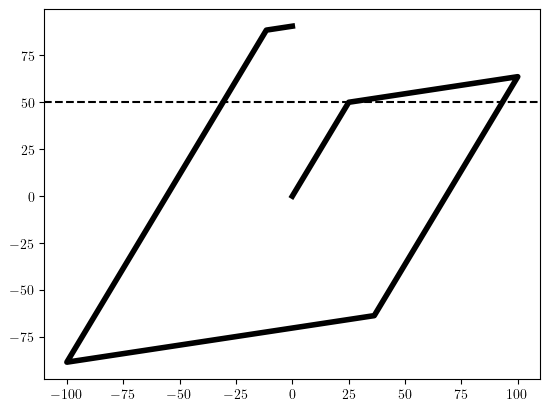

In [156]:
def model_iso(eps,E,Y_F):
    sig = np.zeros_like(eps)
    eps_p = np.zeros_like(eps)
    λ = np.zeros_like(eps)
    Y = np.ones_like(eps)*Y_F(0)

    for i in range(eps.shape[0]-1):
        deps = (eps[i+1] - eps[i])

        sig_trial = sig[i] + E*deps
        
        if abs(sig_trial) - Y[i] <= 0: 
            dλ = 0
        else:
            dλ = (root(
                lambda dλ: abs(sig_trial) - E*dλ - Y_F(λ[i] + dλ), 
                1e-8
            ).x)[0]
        
        deps_p = dλ*sign(sig_trial)
    
        eps_p[i+1] = eps_p[i] + deps_p
        λ[i+1] = λ[i] + dλ
        Y[i+1] = Y_F(λ[i])
        sig[i+1] = sig_trial - E*deps_p
    
    return sig

material = materials["isotropic-linear"]
eps = np.concatenate([np.linspace(0,0.1,1000),np.linspace(0.1,-0.1,1000),np.linspace(-0.1,0,1000)])
sig = model_iso(eps,material['E'],material['Y'])
plt.axhline(material['Y'](0)/1e6,ls='--',color='black')
plt.plot(eps*1e3,sig/1e6,lw=4,color='black')
plt.show()

### Kinematic hardening

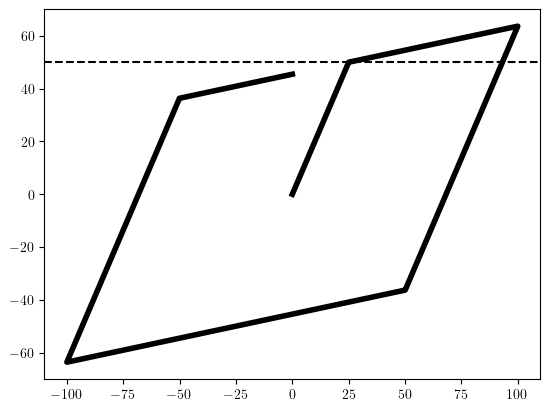

In [157]:
def model_kine_with_epsp(eps,E,f,Y0):
    sig = np.zeros_like(eps)
    eps_p = np.zeros_like(eps)
    λ = np.zeros_like(eps)
    alpha = np.zeros_like(eps)

    for i in range(eps.shape[0]-1):
        deps = (eps[i+1] - eps[i])
        
        sig_trial = sig[i] + E*deps
        
        if abs(sig_trial - alpha[i]) - Y0 <= 0: 
            deps_p = 0
        else:
            def eq(deps_p):
                dλ = deps_p*sign(sig_trial)
                dalpha = f(alpha[i],deps_p,dλ)
                ret =  abs(
                    sig_trial - E*deps_p - alpha[i] + dalpha
                )
                ret -= Y0
                return ret
            
            deps_p = (root(eq,1e-8).x)[0]
        
        
        dλ = deps_p*sign(sig_trial)
        eps_p[i+1] = eps_p[i] + deps_p
        λ[i+1] = λ[i] + dλ
        alpha[i+1] = alpha[i] + f(alpha[i],deps_p,dλ)
        sig[i+1] = sig_trial - E*deps_p
    
    return sig

material = materials['kinematic-linear']

eps = np.concatenate([np.linspace(0,0.1,1000),np.linspace(0.1,-0.1,1000),np.linspace(-0.1,0,1000)])
sig = model_kine_with_epsp(eps,2e9,f=material['dalpha'],Y0=50e6)
plt.axhline(50,ls='--',color='black')
plt.plot(eps*1e3,sig/1e6,lw=4,color='black')
plt.show()

### Mixed hardening

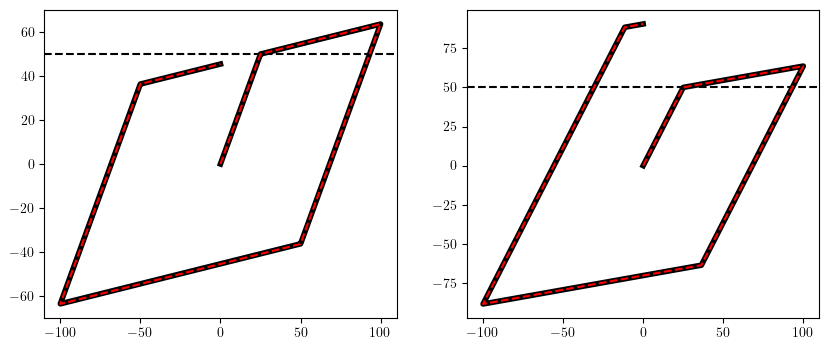

In [158]:
def mixed_hardening(eps,E,dalpha_F,Y_F):
    sig = np.zeros_like(eps)
    eps_p = np.zeros_like(eps)
    λ = np.zeros_like(eps)
    Y = np.ones_like(eps)*Y_F(0)
    alpha = np.zeros_like(eps)

    for i in range(eps.shape[0]-1):
        deps = (eps[i+1] - eps[i])
        
        sig_trial = sig[i] + E*deps
        
        if abs(sig_trial - alpha[i]) - Y[i] <= 0: 
            deps_p = 0
            dλ = 0
        else:
            def eq(deps_p):
                dλ = deps_p*sign(sig_trial)
                ret  = abs(sig_trial - alpha[i] - dalpha_F(alpha[i],deps_p,dλ))
                ret -= E*dλ
                ret -= Y_F(λ[i]+dλ)
                return ret
            
            deps_p = (root(eq,1e-8).x)[0]
            dλ = deps_p*sign(sig_trial)
    
        eps_p[i+1] = eps_p[i] + deps_p
        λ[i+1] = λ[i] + dλ
        Y[i+1] = Y_F(λ[i+1])
        alpha[i+1] = alpha[i] + dalpha_F(alpha[i],deps_p,dλ)
        sig[i+1] = sig_trial - E*deps_p
    
    return sig


fig, ax = plt.subplots(1,2,figsize=(10,4))


eps = np.concatenate([np.linspace(0,0.1,1000),np.linspace(0.1,-0.1,1000),np.linspace(-0.1,0,1000)])


# check the kinematic hardening
material = materials["kinematic-linear"]
sig = model_kine_with_epsp(eps,2e9,f=material['dalpha'],Y0=50e6)
ax[0].axhline(material['Y'](0)/1e6,ls='--',color='black')
ax[0].plot(eps*1e3,sig/1e6,lw=4,color='black')

sig = mixed_hardening(eps,E=material['E'],dalpha_F=material['dalpha'],Y_F=material['Y'])
ax[0].plot(eps*1e3,sig/1e6,color='red',ls='--')

# check the isotropic hardening
material = materials["isotropic-linear"]
sig = model_iso(eps,material['E'],material['Y'])
ax[1].axhline(material['Y'](0)/1e6,ls='--',color='black')
ax[1].plot(eps*1e3,sig/1e6,lw=4,color='black')

sig = mixed_hardening(eps,E=material['E'],dalpha_F=material['dalpha'],Y_F=material['Y'])
ax[1].plot(eps*1e3,sig/1e6,color='red',ls='--')

plt.show()

### Diagrams

In [169]:
def HARDENING(eps,E,dalpha_F,Y_F):
    sig = np.zeros_like(eps)
    eps_p = np.zeros_like(eps)
    λ = np.zeros_like(eps)
    Y = np.ones_like(eps)*Y_F(0)
    alpha = np.zeros_like(eps)

    for i in range(eps.shape[0]-1):
        deps = (eps[i+1] - eps[i])
        
        sig_trial = sig[i] + E*deps
        
        if abs(sig_trial - alpha[i]) - Y[i] <= 0: 
            deps_p = 0
            dλ = 0
        else:
            def eq(deps_p):
                dλ = deps_p*sign(sig_trial)
                ret  = abs(sig_trial - alpha[i] - dalpha_F(alpha[i],deps_p,dλ))
                ret -= E*dλ
                ret -= Y_F(λ[i]+dλ)
                return ret
            
            deps_p = (root(eq,1e-8).x)[0]
            dλ = deps_p*sign(sig_trial)
    
        eps_p[i+1] = eps_p[i] + deps_p
        λ[i+1] = λ[i] + dλ
        Y[i+1] = Y_F(λ[i+1])
        alpha[i+1] = alpha[i] + dalpha_F(alpha[i],deps_p,dλ)
        sig[i+1] = sig_trial - E*deps_p
    
    return sig, alpha, Y

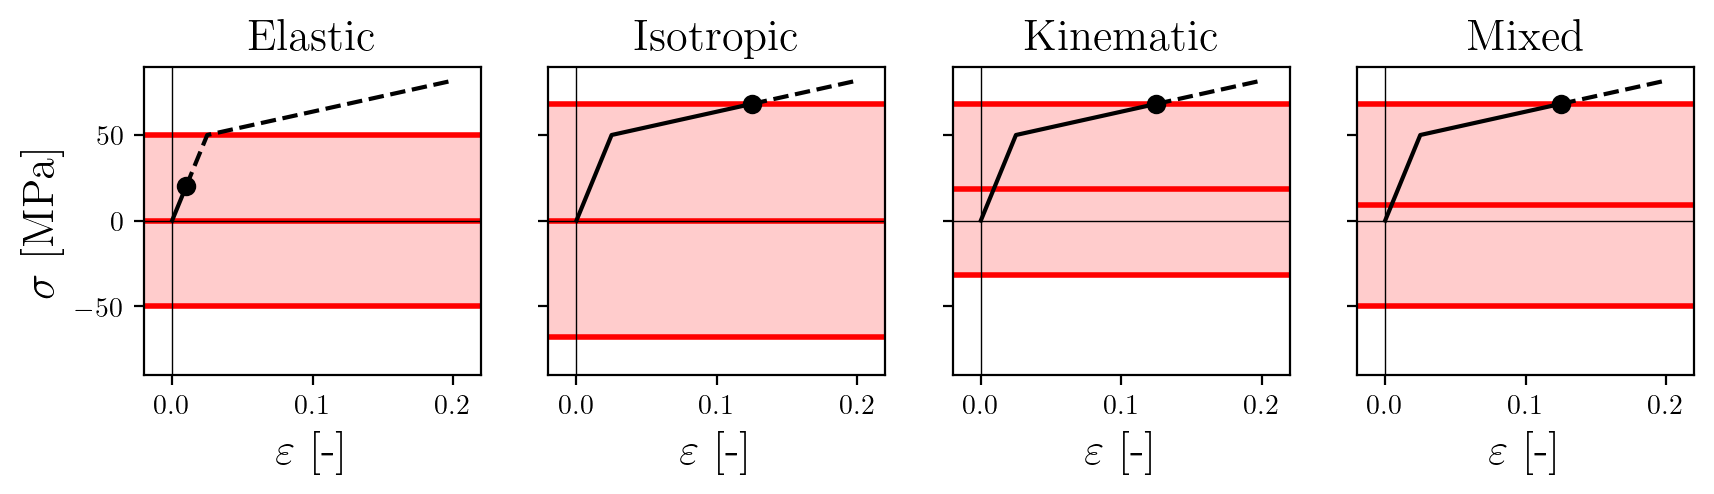

In [161]:
fig, ax = plt.subplots(1,4,figsize=(10,2),dpi=200,sharey=True)

eps2 = 0.2

eps = np.linspace(0,eps2,1000)
ax[0].set_ylabel(r'$\sigma$ [MPa]',fontsize=16)
for i,name,eps1,title in [(0,'kinematic-linear',0.01,'Elastic'),(1,'isotropic-linear',0.125,'Isotropic'),(2,'kinematic-linear',0.125,'Kinematic'),(3,'mixed-linear',0.125,'Mixed')]:
    mat = materials[name]
    sig, alpha, Y = HARDENING(eps,mat['E'],mat['dalpha'],mat['Y']) 
    sig, Y, alpha = sig/1e6, Y/1e6, alpha/1e6


    index = np.abs(eps - eps1).argmin()
    eps1 = eps[index]
    Y1 = Y[index]
    alpha1 = alpha[index]
    sig2 = sig[-1]


    eps_range = np.linspace(eps[0]-eps2*1e2,eps[-1]+eps2*1e2)
    ax[i].fill_between(eps_range, -Y1*np.ones_like(eps_range)+alpha1, Y1*np.ones_like(eps_range)+alpha1, color="red", alpha=0.2, linewidth=0)
    ax[i].plot(eps_range,alpha1*np.ones_like(eps_range), color="red",lw=2)
    ax[i].plot(eps_range, Y1*np.ones_like(eps_range)+alpha1, color="red",lw=2)
    ax[i].plot(eps_range,-Y1*np.ones_like(eps_range)+alpha1, color="red",lw=2)
        
    ax[i].set_xlim(eps[0]-eps2*10e-2,eps[-1]+eps2*10e-2)
    ax[i].set_ylim(-sig2*1.1,sig2*1.1)
    ax[i].plot(eps[:index],sig[:index],color='black')
    ax[i].plot(eps[index],sig[index],color='black',marker='o')
    ax[i].plot(eps[index:],sig[index:],color='black',ls='--')
    
    ax[i].axhline(0,color='black',lw=0.5)
    ax[i].axvline(0,color='black',lw=0.5)
    ax[i].set_title(title,fontsize=16)
    ax[i].set_xlabel(r'$\varepsilon$ [-]',fontsize=16)

plt.show()

# Data generation

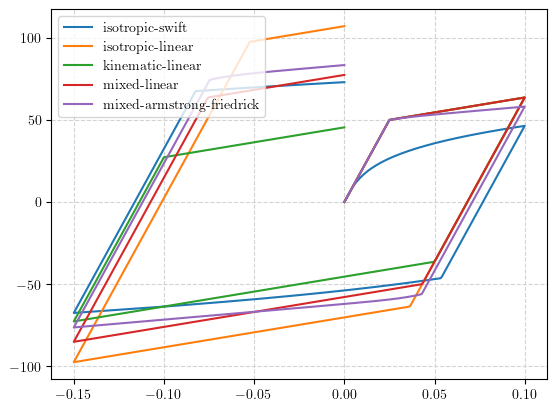

In [224]:
eps = np.concatenate([np.linspace(0,0.1,250),np.linspace(0.1,-0.1,250),np.linspace(-0.15,0,250),])


for name in materials.keys():
    mat = materials[name]
    sig, alpha, Y = HARDENING(eps,mat['E'],mat['dalpha'],mat['Y'])
    plt.plot(eps,sig/1e6,label=name)
plt.legend()
plt.grid(ls='--',c='lightgray')
plt.show()

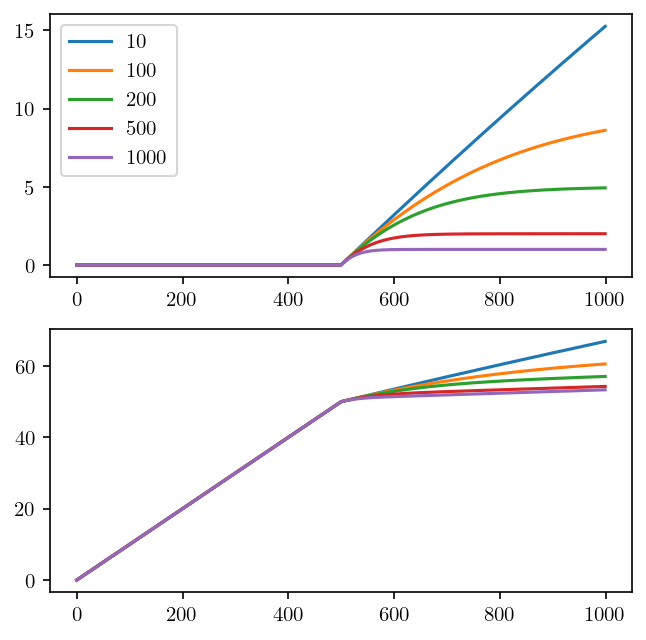

In [203]:
fig, ax = plt.subplots(2,1,figsize=(5,5),dpi=150)

eps = np.linspace(0, 0.05, 1000)
material = materials['mixed-armstrong-friedrick']

for b in [10,100,200,500,1000]:
    sig, alpha, Y = HARDENING(
        eps,
        material['E'],
        lambda alpha, deps_p, dλ : 1000e6*deps_p-dλ*b*alpha,
        material['Y'],
        )
    ax[0].plot(alpha[0:1000]/1e6,label=b)
    ax[1].plot(sig[0:1000]/1e6,label=b)
    ax[0].legend()
plt.show()

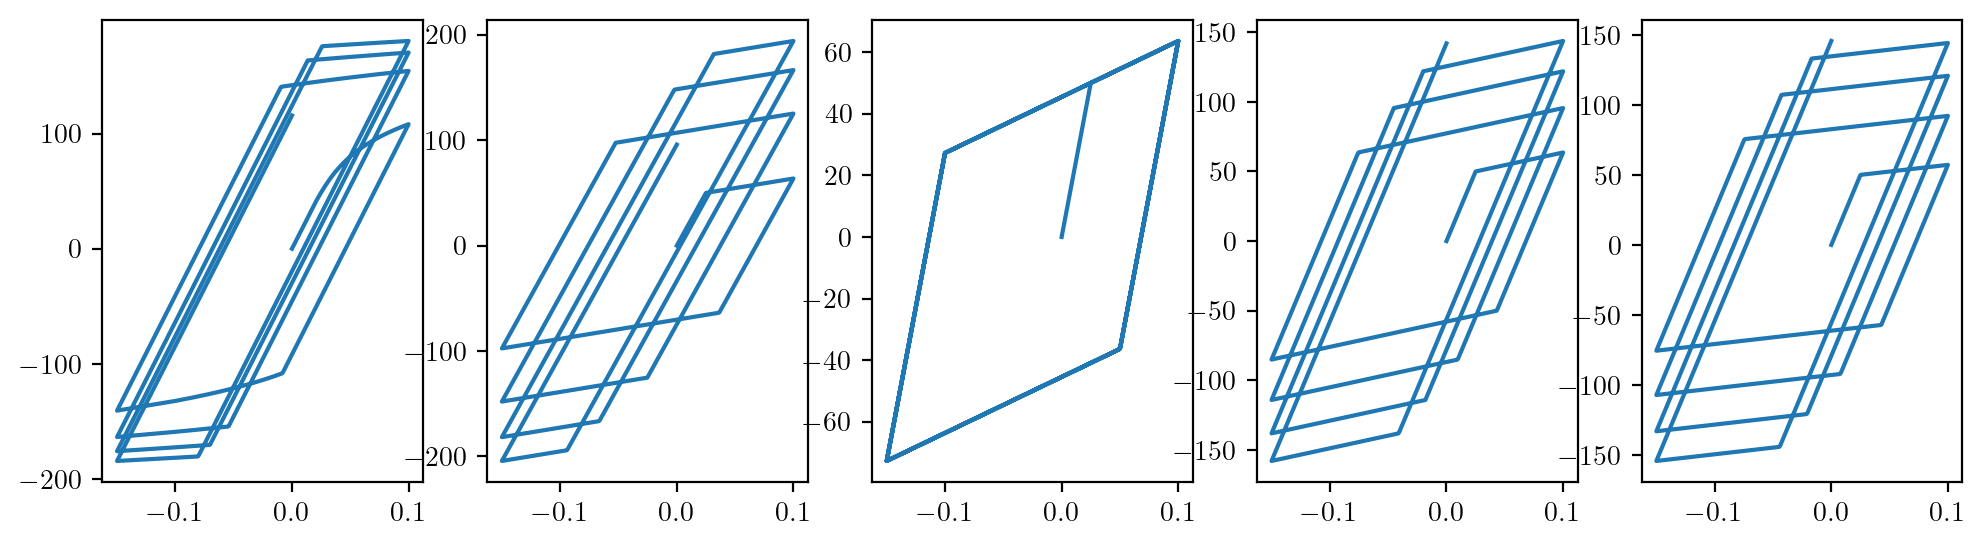

In [135]:
fig, ax = plt.subplots(1,len(list(materials.keys())),figsize=(12,3),dpi=200)

eps = np.concatenate([eps,eps])

for i,name in enumerate(list(materials.keys())):
    mat = materials[name]
    sig = HARDENING(eps,mat['E'],mat['dalpha'],mat['Y'])
    ax[i].plot(eps,sig/1e6,label=name)

In [ ]:
u_list = np.load('swift1/u_list.npy')
u_list.shape

In [137]:
mat = materials['linear1']
y_list = np.array([mixed_hardening(u,mat['E'],mat['alpha'],mat['Y']) for u in u_list])
np.save('linear1/u_list.npy',u_list)
np.save('linear1/y_list.npy',y_list)

In [138]:
mat = materials['linear2']
y_list = np.array([mixed_hardening(u,mat['E'],mat['alpha'],mat['Y']) for u in u_list])
np.save('linear2/u_list.npy',u_list)
np.save('linear2/y_list.npy',y_list)